
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [3013]:
import autograd.numpy as np 
import matplotlib.pyplot as plt
from fgbuster import CMB, Dust, Synchrotron, MixingMatrix
from fgbuster.observation_helpers import standardize_instrument, get_observation
from fgbuster.cosmology import _get_Cl_cmb, _get_Cl_noise
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import healpy as hp
import numdifftools.core as nd
import math as m
from fgbuster.algebra import  W_dBdB, W_dB, W, _mmm, _utmv, _mmv, comp_sep
import pylab as pl



## 1.general parameters

In [3014]:
nside = 64
model = 'd0s0'

Load the instrument

In [3015]:
instr = np.load('/Users/alicepirotta/Desktop/APC/MCMC/instrument_LB_IMOv1.npy', allow_pickle=True).item()
instr_ = {}
instr_['frequency'] = np.array([instr[f]['freq'] for f in instr.keys()])
instr_['depth_p'] = np.array([instr[f]['P_sens'] for f in instr.keys()])
instr_['fwhm'] = np.array([instr[f]['beam'] for f in instr.keys()])
instr_['depth_i'] = instr_['depth_p']/np.sqrt(2)
instrument = standardize_instrument(instr_)

Get the frequency maps 

In [3016]:
d_fgs_N = get_observation(instrument, model, noise=True, nside=nside)
d_fgs = get_observation(instrument, model, noise=False, nside=nside)

#take only the Q and U, not I
freq_maps_N= d_fgs_N[:,1:,:]
freq_maps= d_fgs[:,1:,:]

n_stokes = freq_maps.shape[1]
n_freqs = freq_maps.shape[0]




Chose the components to fit for

In [3017]:
components= [CMB(), Dust(150.), Synchrotron(150.)]

In [3018]:
M = MixingMatrix(*components) 
M_ev = M.evaluator(instrument.frequency)


Define the noise covariance matrix

In [3019]:
N = np.diag((instrument.depth_p / hp.nside2resol(nside, arcmin=True))**2)
invN = np.linalg.inv(N)


## 2.component separation

true and initial values for the parameters

In [3020]:
gains_true = np.ones(21)
x_true = np.concatenate((M.defaults, gains_true))

x_init = np.random.uniform(low=x_true * (1 - 1 / 40), high= x_true * (1 + 1 / 40))

#### average spectral likelihood

In [3021]:
dati = np.einsum('ijp,klp-> ijkl',freq_maps,freq_maps)
print(M_ev(np.array([1.54,20,-3])).shape)


(22, 3)


In [3022]:
def aver_likelihood(y):
    Bd, T, Bs, a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, s, t, u, v, w, z = y
    r= 1
    G = np.diag([a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, r, s, t, u, v, w, z ])
    A_maxL =G.dot(M_ev(np.array([Bd,T,Bs]))) 
    logL = 0
    AtN = A_maxL.T.dot(invN)
    NA= invN.dot(A_maxL)
    AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
    P = NA.dot(AtNA).dot(AtN)
    logL = logL -np.trace(np.einsum('fg, gikj->fk', P, dati)+np.einsum('fg, ij->gi', P, N))

    if logL != logL:
        return 0.0
    return logL

In [3023]:
aver_likelihood(x_true)

-31300490262.32101

#### step1: minimization of the average spectral likelihood

In [3024]:
bnds = ((1.4, 1.6), (10, 30), (-3.5,-2.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5))
options={'maxfun':50000}
result= minimize(aver_likelihood, x_true, method='TNC', tol = 1e-18, options=options, bounds=bnds )
print(result)
print(result.x)

 message: Converged (|f_n-f_(n-1)| ~= 0)
 success: True
  status: 1
     fun: -31300490262.32105
       x: [ 1.540e+00  2.000e+01 ...  1.000e+00  1.000e+00]
     nit: 4
     jac: [ 3.815e+02  3.815e+02 ...  7.629e+02  3.815e+02]
    nfev: 1325
[ 1.54       20.00000008 -2.99999996  1.00000019  0.99999998  1.00000014
  0.99999997  0.99999998  1.00000006  0.99999995  1.          0.99999992
  1.00000001  0.99999998  1.          0.99999995  0.99999995  1.00000003
  0.99999998  1.00000004  1.00000005  0.99999998  1.00000007  0.99999998]


Calculate the errors of the parameters

In [3025]:
H = nd.Hessian(aver_likelihood)
h = H(result.x)

sigma_params_square = np.linalg.inv(h)
sigma_params_square=sigma_params_square.T
print(sigma_params_square)

#Hessian should be only 3,3

[[-3.33000390e-02  4.16480746e-01 -3.18597803e-02 -4.37273391e-02
  -3.66546980e-02 -3.08970698e-02 -2.69634230e-02 -2.69634209e-02
  -2.26787996e-02 -2.26787943e-02 -1.85942047e-02 -1.85942002e-02
  -1.50208760e-02 -9.75874547e-03 -4.93592249e-03 -1.50208742e-02
  -9.75874490e-03 -4.93592281e-03  4.52794101e-03  4.52794151e-03
   9.56741231e-03  1.40462469e-02  1.84456145e-02  2.22260116e-02]
 [ 4.16480756e-01 -1.81494203e+01  3.43750730e-01  4.23067965e-01
   3.47803944e-01  2.87230674e-01  2.46459749e-01  2.46459726e-01
   2.02885566e-01  2.02885519e-01  1.62396045e-01  1.62396004e-01
   1.28016954e-01  7.96256635e-02  3.82946224e-02  1.28016938e-01
   7.96256589e-02  3.82946249e-02 -3.03350968e-02 -3.03351001e-02
  -5.65743033e-02 -7.02862776e-02 -7.01714189e-02 -5.23776305e-02]
 [-3.18597802e-02  3.43750719e-01 -2.86808234e-02 -4.03230538e-02
  -3.39226855e-02 -2.87106087e-02 -2.51447485e-02 -2.51447465e-02
  -2.12430736e-02 -2.12430687e-02 -1.74940069e-02 -1.74940027e-02
  -1.418

definition of A=G*M

In [3026]:
def G_tot(gain_params):
    a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, s, t, u, v, w, z = gain_params
    r= 1
    G = np.diag([a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, r, s, t, u, v, w, z ])
    return G

In [3027]:
#modified
def A_ev_new(y):
    Bd, T, Bs, a, b, c, d, e, f, g, i, l, m, n, o, p, q, r, s, t, u, v, w, z = y
    h = 1
    G = np.diag([a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, r, s, t, u, v, w, z ])
    A_maxL =G.dot(M_ev(np.array([Bd,T,Bs])))
    print(A_maxL.shape)
    return A_maxL

In [3028]:
#evaluate the matrix A at maximum of the average likelihood

A_maxL=A_ev_new(result.x) #(n_freq,n_component) #modified
print(A_maxL.shape)


(22, 3)
(22, 3)


#### step2: take the component maps (residual, dust, synch)
the first one should be CMB, but I have no CMB, so it is residual

In [3029]:
AtN=A_maxL.T.dot(invN)
AtNA=np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))


comp_maps=np.einsum ('cg,gs,sij->cij', AtNA,AtN, freq_maps)


residual_maps_QU = comp_maps[0]
zeros=np.zeros((1, 49152))
residual_maps_IQU = np.vstack((zeros, residual_maps_QU))



## 3. total residual power spectrum

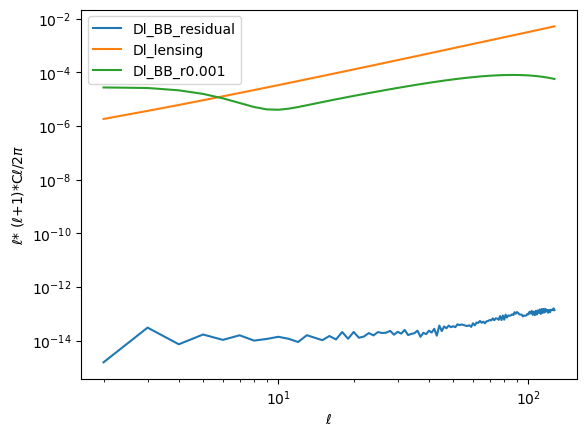

In [3030]:
#multipole range 
lmin= 2
lmax= 2*nside-1
ell = np.arange(lmin,lmax+1)


# #power spectrum of the total residual 
Cl_BB_residual =hp.anafast(residual_maps_IQU)[2,lmin:lmax+1] #with [2] I select the B mode #closed to bias
Dl_BB_residual = (ell*(ell+1)*Cl_BB_residual)/(2*m.pi)


#Cl theory 
Cl_BB_r1 = _get_Cl_cmb(Alens=0.0, r=1.)[2][lmin:lmax+1]
Cl_BB_r_001 = _get_Cl_cmb(Alens=0.0, r=0.001)[2] [lmin:lmax+1]

#Dl theory
Dl_BB_r001 = (ell*(ell+1)*Cl_BB_r_001)/(2*m.pi)


#lensing
Cl_lens = _get_Cl_cmb(Alens=1.0, r=0.)[2][lmin:lmax+1]
Dl_lens = (ell*(ell+1)*Cl_lens)/(2*m.pi)

#plot power spectra
plt.loglog(ell, Dl_BB_residual, label = "Dl_BB_residual")
plt.loglog(ell, Dl_lens, label = "Dl_lensing")
plt.loglog(ell, Dl_BB_r001, label = "Dl_BB_r0.001")
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell$* ($\ell$+1)*C$\ell$/2$\pi$')
plt.legend()



## 4.Calculate sigma Fisher

In [3031]:
Data = Cl_BB_residual + Cl_lens #it is needed by the cosmological likelihood
fsky = 1
F = np.sum((2*ell+1) * fsky / 2*Cl_BB_r1** 2 / Data ** 2) #it is a scalar because I am using comsological likelihood
sigma_r_fisher = np.sqrt(1.0 / F)

In [3032]:
i_cmb = M.components.index('CMB')
W_maxL = np.einsum ('cg,gs->cs', AtNA,AtN)[i_cmb,:]


In [3033]:


#this function takes the gain parameters 21 from the minimization and add the one that is fixed at 1
def G_values_tot(gain_params):
    a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, s, t, u, v, w, z = gain_params
    r= 1
    G = [a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, r, s, t, u, v, w, z]
    return G

gain_params_tot= G_values_tot(result.x[3:])
# gain_params_tot= G_values_tot(np.ones(21))  #modified


#it gives you the derivative of the gain respect to each gains
def G_diff(gain_params_tot_):
    G_dB = []
    for i,_ in enumerate(result.x[3:]):
        zeros= np.zeros((len(gain_params_tot_),len(gain_params_tot_)))
        zeros[i] = 1
        G_dB.append(zeros)
    return np.array(G_dB)



def zeros(M_dB_):
    M_dB=[]
    zero_column=np.zeros(22)
    for i,_ in enumerate(result.x[:3]):
        if i == 2: 
            M_dB_tot=np.vstack((zero_column,zero_column,M_dB_[i,:,0], zero_column, zero_column, zero_column, 
                                zero_column, zero_column, zero_column, zero_column, zero_column, zero_column, 
                                zero_column, zero_column, zero_column, zero_column, zero_column, zero_column, 
                                zero_column, zero_column, zero_column, zero_column, zero_column, zero_column))   
        else:
            M_dB_tot=np.vstack((zero_column,M_dB_[i,:,0], zero_column, zero_column, zero_column, zero_column, 
                                zero_column, zero_column, zero_column, zero_column, zero_column, zero_column, 
                                zero_column, zero_column, zero_column, zero_column, zero_column, zero_column, 
                                zero_column, zero_column, zero_column, zero_column, zero_column, zero_column))
        M_dB.append(M_dB_tot)
    return np.array(M_dB)




def A_diff_new(params_values):
    spectral_params_values = params_values[:3]
    # gain_params_values = params_values[3:]
    

    #first term
    G_dB=G_diff(gain_params_tot)  #(gain_param,freq,freq)=(21,22,22)
    zeros_matrix=np.zeros((3,22,22))
    G_dB_tot= np.concatenate((zeros_matrix,G_dB), axis=0) #(param, freq, freq)=(24,22,22)
  

    M_ev_val = M_ev(spectral_params_values) #(freq,component)=(22,3)
    # derivatives of G wrt. spectral parameters is zero
    G_dB_M = np.einsum('gif, fc-> gci',  G_dB_tot, M_ev_val) #(param, component, freq)= (24, 3, 22)
   
    

    #second term
    M_dB_ev = M.diff_evaluator(instrument.frequency)
    M_dB_val = np.array(M_dB_ev(spectral_params_values))#(spec_param,freq,component)=(3,22,1)
    M_dB_tot=zeros(M_dB_val)#(component, param, freq)=(3,24,22)
    M_dB_tot=np.array(M_dB_tot)
   

    G = np.diag(np.array(gain_params_tot)) #(freq,freq)=(22,22)
    # G = np.eye(22,22) #modified
    G_M_dB_val = np.einsum('abc, cd-> bad', M_dB_tot,G) #(param, component, freq)= (24,3,22)
  
 
    A_dB_new= G_dB_M+G_M_dB_val#(params,freq,component)=(24,22,3)

    return A_dB_new


A_dB_maxL= A_diff_new(result.x)
print(A_dB_maxL.shape)

(24, 3, 22)


## estimation of the statistical and systematics residuals

In [3034]:
def A_diff_diff_new(params_values):
    spectral_params_values = params_values[:3]
    # gain_params_values = params_values[3:]
    
    #first term
    G_dB=G_diff(gain_params_tot)  #(gain_param,freq,freq)=(21,22,22)
    zeros_matrix=np.zeros((3,22,22))
    G_dB_tot= np.concatenate((zeros_matrix,G_dB), axis=0) #(param, freq, freq)=(24,22,22)
    
    M_dB_ev = M.diff_evaluator(instrument.frequency)
    M_dB_val = np.array(M_dB_ev(spectral_params_values))#(spec_param,freq,component)=(3,22,1)
    M_dB_tot=zeros(M_dB_val)#(component, param, freq)=(3,24,22)
    M_dB_tot=np.array(M_dB_tot)

    G_dB_M_dB = np.einsum('abc,dec->aedb', G_dB_tot,M_dB_tot) #(24,24,3,22)
    
    

    # #second term
    M_dB_dB_ev = M.diff_diff_evaluator(instrument.frequency)
    M_dB_dB_val= np.array(M_dB_dB_ev(spectral_params_values))#(3,3)

   
 

    M_dB_dB_all = np.zeros((24,24,3,22))
    M_dB_dB_all[0,0,0]= M_dB_dB_val[0,0][:,0]
    M_dB_dB_all[0,1,1]= M_dB_dB_val[0,1][:,0]
    M_dB_dB_all[1,1,0]= M_dB_dB_val[1,0][:,0]
    M_dB_dB_all[1,1,1]= M_dB_dB_val[1,1][:,0]
    M_dB_dB_all[2,2,2]= M_dB_dB_val[2,1][:,0]
    print(M_dB_dB_all)

    

    # M_dB_dB_zeros=zeros_new(M_dB_dB_val)
    # print(M_dB_dB_zeros)
    # zeros_matrix_new=np.zeros((21,3,22,3))
    # M_dB_dB_tot=np.concatenate((M_dB_dB_zeros,zeros_matrix_new), axis=0)
    # M_dB_dB_tot=np.array(M_dB_dB_tot
    # M_dB_dB_prova= np.zeros((24,24,22,3))
    # G = np.diag(np.array(gain_params_tot)) #(freq,freq)=(22,22)
    # M_dB_dB_G= np.einsum('abcd,ce->abed', M_dB_dB_prova,G)
   
    A_dB_dB_new=  G_dB_M_dB +  G_dB_M_dB +M_dB_dB_all
    print(A_dB_dB_new.shape)

  
    return A_dB_dB_new

A_dBdB_maxL= A_diff_diff_new(result.x)


[[[[ 1.57188730e-01  1.54788568e-01  1.44838478e-01 ...  2.78250087e+00
     1.09590439e+01  4.32107020e+01]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]]

  [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 8.44271872e-04  9.12680832e-04  9.24944922e-04 ...  4.06889477e-02
     1.81084581e-01  8.06401486e-01]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]]

  [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]]

  ...

  [[ 0

/Users/alicepirotta/miniforge3/envs/gain_env/lib/python3.9/site-packages/autograd/numpy/numpy_wrapper.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return _np.array(args, *array_args, **array_kwargs)


In [3035]:
#W_dB_maxL

a = -np.linalg.inv(np.einsum('cf, fx, xs-> cs',A_maxL.T, invN, A_maxL)) #(3,3)
b = np.einsum('fcg, fx, xs-> cgs',A_dB_maxL.T, invN, A_maxL)+ np.einsum('cf, fx, gsx-> cgs',A_maxL.T, invN, A_dB_maxL)
#(3,24,3)
c = np.linalg.inv(np.einsum('cf, fx, xs-> cs',A_maxL.T, invN, A_maxL))#(3,3)
d = np.einsum('fcg, fx-> cgx',A_dB_maxL.T, invN)#(3,24,22)
e = np.einsum( 'cf, fx-> cx', A_maxL.T, invN)#(3,22)
f = np.einsum ( 'ab, bcd-> acd', a,b)
g = np.einsum ( 'ab, bc-> ac', c,e)


W_dB_maxL = np.einsum('abc, cd-> bad', f,g) + np.einsum('cx, xgf-> gcf', c, d)  #(params_tot,component,freq)=(24,3,22)
print(W_dB_maxL)
W_dB_maxL = W_dB_maxL [:, i_cmb]




[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]]

 [[-4.03821687e-02 -1.99452557e-02 -1.63158200e-02 ... -4.73953196e-02
   -3.32867007e-02  1.37844192e-04]
  [ 2.86447517e-02  1.49930835e-02  1.42187201e-02 ...  4.24426751e-03
    2.09569389e-02  1.44737961e-02]
  [ 3.96177099e-03  1.84238186e-03  1.24265541e-03 ...  8.62412437e-03
    3.62226697e-03 -1.98810090e-03]]

 [[-1.88250100e-02 -1.56947752e-02 -2.52417630e-02 ...  4.48645529e-03
   -4.28310833e-03 -4.63511311e-03]
  [ 2.86402428e-04  5.01124384e-04  1.01026995e-03 ... -2.41126359e-04
    1.98291563e-04  2.20813613e-04]
  [ 1.71362696e-02  1.25827135e-02  1.89094776e-02 ... -2.96107057e-03
    3.03411313e-03  3.24303026e-03]]

 ...

 [[-5.31378498e-02 -3.303

In [3036]:
#W_dB_dB_maxL

h = np.einsum ( 'bacd,be,ef->cdaf', A_dBdB_maxL.T, invN, A_maxL )
i = np.einsum ( 'bac,bd,efd->ceaf', A_dB_maxL.T, invN, A_dB_maxL )
l = np.einsum ( 'ab,bc,defc->deaf', A_maxL.T,invN, A_dBdB_maxL)

p = h+i+i+l
o = np.einsum (  'ab,bc,cd->ad', a,c,e)


H = np.einsum('ab,bcd,de,efg,gh,hi->cfai', a,b,c,b,c,e)
#print(H.shape)
B =  np.einsum ( 'ab,cdea->cdeb',o,p)
#print(B.shape)
C = np.einsum('ab,bcd,de,fg,ghi,if->chae', a,b,e,a,b,c)
#print(C.shape)
D = np.einsum('ab,bcd,de,efg->cfag', a,b,c,d)
#print(D.shape)
E = np.einsum ('ab,cbde,cf->deaf', c,A_dBdB_maxL.T,invN)
#print (E.shape)


W_dB_dB_maxL = - H + B + C + D + D + E
print(W_dB_dB_maxL)
W_dB_dB_maxL =  W_dB_dB_maxL[:, :, i_cmb]

[[[[-9.78034251e-03 -4.32264271e-03 -2.19613626e-03 ...  1.21905556e-01
     1.88226582e-01  1.62061923e-01]
   [ 4.25278092e-01  2.28112529e-01  2.29639696e-01 ... -1.24272476e-02
     2.86884178e-01  2.38156501e-01]
   [ 1.98926966e-02  1.05469629e-02  1.03338702e-02 ... -2.36453925e-02
    -2.23588747e-02 -1.90495498e-02]]

  [[-4.28301892e-05 -2.27730705e-05 -2.24318011e-05 ... -1.06477560e-05
    -4.24618659e-05 -3.28141897e-05]
   [-9.16840005e-04 -4.87489373e-04 -4.80184025e-04 ... -2.27930085e-04
    -9.08955531e-04 -7.02433551e-04]
   [-3.11171688e-05 -1.65451868e-05 -1.62972463e-05 ... -7.73585237e-06
    -3.08495731e-05 -2.38403029e-05]]

  [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]]

  ...

  [[ 0

In [3037]:
if n_stokes == 3:  
    d_spectra = freq_maps
else:  # Only P is provided, add T for map2alm
    d_spectra = np.zeros((n_freqs, 3, freq_maps.shape[2]), dtype=freq_maps.dtype)
    d_spectra[:, 1:] = freq_maps

# Compute cross-spectra
almBs = [hp.map2alm(freq_map, lmax=lmax, iter=10)[2] for freq_map in d_spectra]
Cl_fgs = np.zeros((n_freqs, n_freqs, lmax+1), dtype=freq_maps.dtype)
for f1 in range(n_freqs):
    for f2 in range(n_freqs):
        if f1 > f2:
            Cl_fgs[f1, f2] = Cl_fgs[f2, f1]
        else:
            Cl_fgs[f1, f2] = hp.alm2cl(almBs[f1], almBs[f2], lmax=lmax)

Cl_fgs = Cl_fgs[..., lmin:] / fsky

In [3038]:

V_maxL = np.einsum('ij,ij...->...', sigma_params_square, W_dB_dB_maxL)



# Check dimentions
assert ((n_freqs,) == W_maxL.shape == W_dB_maxL.shape[1:]== W_dB_dB_maxL.shape[2:] == V_maxL.shape)
assert (len(result.x) == W_dB_maxL.shape[0] == W_dB_dB_maxL.shape[0] == W_dB_dB_maxL.shape[1])

# elementary quantities defined in Stompor, Errard, Poletti (2016)
Cl_xF = {}
Cl_xF['yy'] = _utmv(W_maxL, Cl_fgs.T, W_maxL)  # (ell,)= (191)
Cl_xF['YY'] = _mmm(W_dB_maxL, Cl_fgs.T, W_dB_maxL.T)  # (ell, param, param)=(191,24,24)
Cl_xF['yz'] = _utmv(W_maxL, Cl_fgs.T, V_maxL )  # (ell,)
Cl_xF['Yy'] = _mmv(W_dB_maxL, Cl_fgs.T, W_maxL)  # (ell, param)
Cl_xF['Yz'] = _mmv(W_dB_maxL, Cl_fgs.T, V_maxL)  # (ell, param)

print(Cl_xF['Yz'])


Cl_noise = _get_Cl_noise(instrument, A_maxL, lmax)[ i_cmb,  i_cmb, lmin:]

# bias and statistical foregrounds residuals
noise = Cl_noise
bias = Cl_xF['yy'] + 2 * Cl_xF['yz'] #should be 0 
stat = np.einsum('ij, lij -> l', sigma_params_square, Cl_xF['YY'])  
var = stat**2 + 2 * np.einsum('li, ij, lj -> l', Cl_xF['Yy'], sigma_params_square, Cl_xF['Yy'])
# noise_stat= noise + stat


#control that Cl_BB_residual = noise + stat


[[ 0.00000000e+00  1.99287922e+02 -7.34459553e+01 ... -3.21248581e+04
  -1.44278662e+03  1.96119045e+04]
 [ 0.00000000e+00  1.55624505e+03 -2.61013641e+03 ... -2.55981546e+05
  -1.14966035e+04  1.56274173e+05]
 [ 0.00000000e+00  1.61944582e+02 -2.50435708e+02 ... -2.65845015e+04
  -1.19395891e+03  1.62295721e+04]
 ...
 [ 0.00000000e+00  6.93620381e-02 -1.83759237e-02 ... -1.11629666e+01
  -5.01349432e-01  6.81487982e+00]
 [ 0.00000000e+00  9.21265829e-02  1.31205242e-02 ... -1.47323529e+01
  -6.61657373e-01  8.99395480e+00]
 [ 0.00000000e+00  7.83114108e-02 -1.45055010e-02 ... -1.25875756e+01
  -5.65331506e-01  7.68458926e+00]]


In [3039]:
# lmin= 2
# lmax= 192
# ell = np.arange(lmin,lmax)

# plt.loglog(ell, Cl_BB_r_001, label = "Cl_BB_r0.001") 
# plt.loglog(ell, Cl_BB_residual, label = "Cl_BB_residual")



# lmin= 1
# lmax= 192
# ell = np.arange(lmin,lmax)

# plt.loglog(ell, noise , label = "noise ")
# # plt.loglog(ell, bias , label = "bias")
# # plt.loglog(ell, stat , label = "stat")
# # plt.loglog(ell,var, label = "var")
# # plt.loglog(ell,noise_stat, label = "noise+stat")

# plt.xlabel(r'$\ell$')
# plt.ylabel(r'Cl')
# plt.legend()

In [3040]:
# lmin= 2
# lmax= 192
# ell = np.arange(lmin,lmax)

# plt.loglog(ell, Cl_BB_r_001, label = "Cl_BB_r0.001") 
# plt.loglog(ell, Cl_BB_residual, label = "Cl_BB_residual")



# lmin= 1
# lmax= 192
# ell = np.arange(lmin,lmax)

# #plt.loglog(ell, noise , label = "noise ")
# plt.loglog(ell, bias , label = "bias")
# # plt.loglog(ell, stat , label = "stat")
# # plt.loglog(ell,var, label = "var")
# # plt.loglog(ell,noise_stat, label = "noise+stat")

# plt.xlabel(r'$\ell$')
# plt.ylabel(r'Cl')
# plt.legend()

In [3041]:
# lmin= 2
# lmax= 192
# ell = np.arange(lmin,lmax)

# plt.loglog(ell, Cl_BB_r_001, label = "Cl_BB_r0.001") 
# plt.loglog(ell, Cl_BB_residual, label = "Cl_BB_residual")



# lmin= 0
# lmax= 191
# ell = np.arange(lmin,lmax)

# #plt.loglog(ell, noise , label = "noise ")
# # plt.loglog(ell, bias , label = "bias")
# plt.loglog(ell, stat , label = "stat")
# # plt.loglog(ell,var, label = "var")
# # plt.loglog(ell,noise_stat, label = "noise+stat")

# plt.xlabel(r'$\ell$')
# plt.ylabel(r'Cl')
# plt.legend()

In [3042]:
# lmin= 2
# lmax= 192
# ell = np.arange(lmin,lmax)

# plt.loglog(ell, Cl_BB_r_001, label = "Cl_BB_r0.001") 
# plt.loglog(ell, Cl_BB_residual, label = "Cl_BB_residual")



# lmin= 1
# lmax= 192
# ell = np.arange(lmin,lmax)

# #plt.loglog(ell, noise , label = "noise ")
# # plt.loglog(ell, bias , label = "bias")
# # plt.loglog(ell, stat , label = "stat")
# plt.loglog(ell,var, label = "var")
# # plt.loglog(ell,noise_stat, label = "noise+stat")

# plt.xlabel(r'$\ell$')
# plt.ylabel(r'Cl')
# plt.legend()

(2, 127)

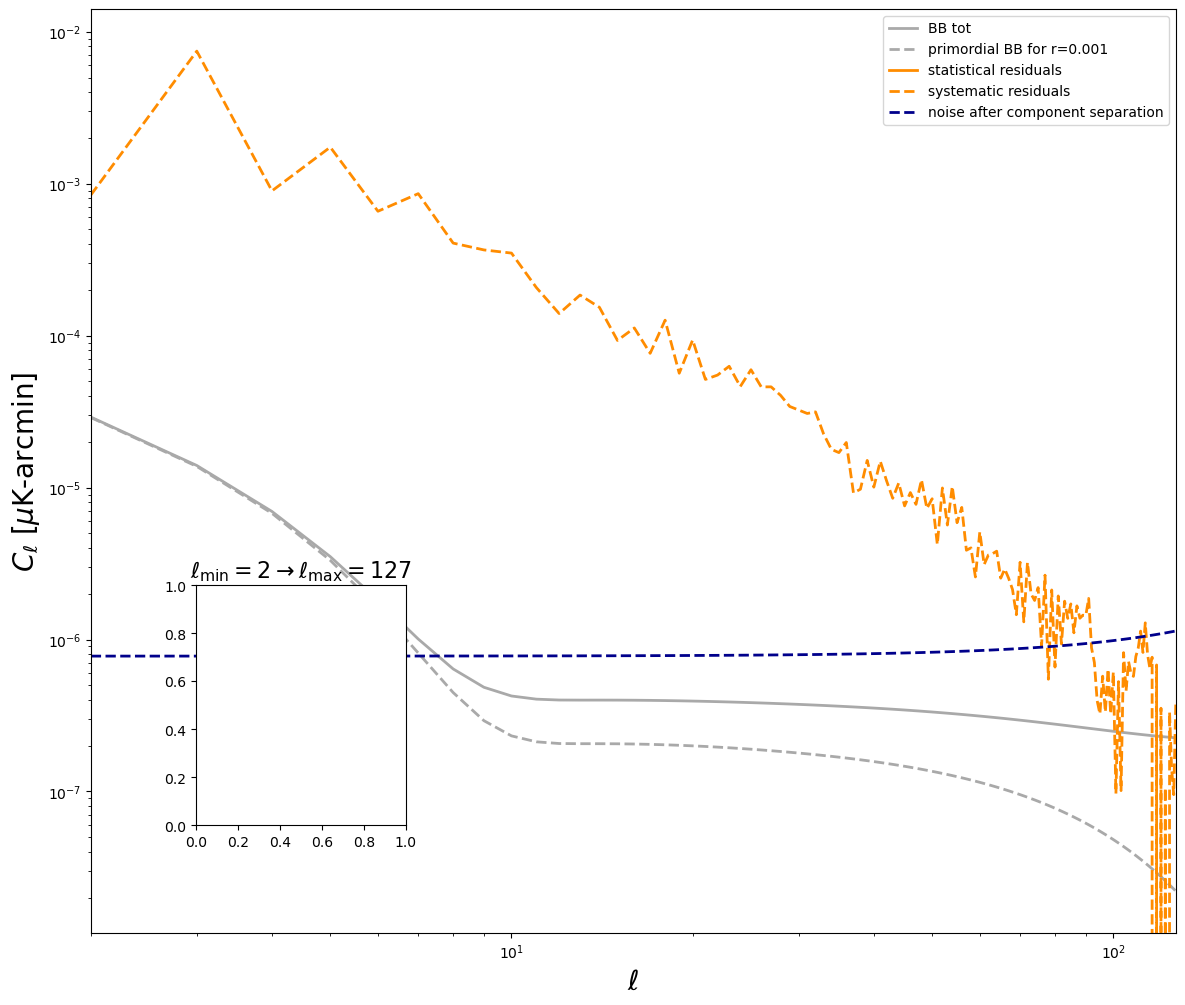

In [3043]:
lmin= 2
lmax= 127
ell = np.arange(lmin, lmax+1)


Cl_fid = {}
Cl_fid['BB'] = _get_Cl_cmb(Alens=0.1, r=0.001)[2][lmin:lmax+1]
Cl_fid['BuBu'] = _get_Cl_cmb(Alens=0.0, r=1.0)[2][lmin:lmax+1]
Cl_fid['BlBl'] = _get_Cl_cmb(Alens=1.0, r=0.0)[2][lmin:lmax+1]



fig = pl.figure( figsize=(14,12), facecolor='w', edgecolor='k' )
ax = pl.gca()
left, bottom, width, height = [0.2, 0.2, 0.15, 0.2]
ax0 = fig.add_axes([left, bottom, width, height])
ax0.set_title(r'$\ell_{\min}=$'+str(lmin)+\
    r'$ \rightarrow \ell_{\max}=$'+str(lmax), fontsize=16)

ax.loglog(ell, Cl_fid['BB'], color='DarkGray', linestyle='-', label='BB tot', linewidth=2.0)
ax.loglog(ell, Cl_fid['BuBu']*0.001 , color='DarkGray', linestyle='--', label='primordial BB for r='+str(0.001), linewidth=2.0)
ax.loglog(ell, stat, 'DarkOrange', label='statistical residuals', linewidth=2.0)
ax.loglog(ell, bias, 'DarkOrange', linestyle='--', label='systematic residuals', linewidth=2.0)
ax.loglog(ell, noise, 'DarkBlue', linestyle='--', label='noise after component separation', linewidth=2.0)
ax.legend()
ax.set_xlabel('$\ell$', fontsize=20)
ax.set_ylabel('$C_\ell$ [$\mu$K-arcmin]', fontsize=20)
ax.set_xlim(lmin,lmax)

ValueError: x and y must have same first dimension, but have shapes (190,) and (126,)

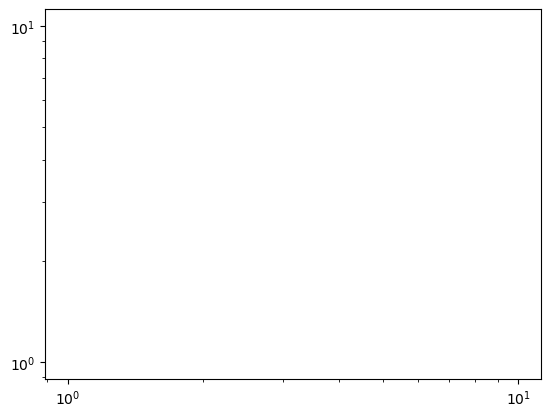

In [3044]:
lmin= 2
lmax= 192
ell = np.arange(lmin,lmax)

plt.loglog(ell, Cl_BB_r_001, label = "Cl_BB_r0.001") 
plt.loglog(ell, Cl_BB_residual, label = "Cl_BB_residual")



lmin= 2
lmax= 193
ell = np.arange(lmin,lmax)

plt.loglog(ell, noise , label = "noise ")
plt.loglog(ell, bias , label = "bias")
plt.loglog(ell, stat , label = "stat")
plt.loglog(ell,var, label = "var")
#plt.loglog(ell,noise_stat, label = "noise+stat")

plt.xlabel(r'$\ell$')
plt.ylabel(r'Cl')
plt.legend()